In [50]:
# Import relevant libraries

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns

import pandas as pd
pd.set_option('display.max_columns', 100)
pd.options.display.width=None

from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve

from sklearn.linear_model import LogisticRegression
import catboost as cb

In [51]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [52]:
PATH = r"C:\DSML_Case_Studies_2021.04.24\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies_2021.04.24\03_Output"
DATASET = r"\Dataset_CC_Rawdata_23x1.csv"
PREFIX = r"\CC_Rawdata_"

#Specify number of features and targets

n_features = 23
n_target = 1

In [53]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
# df = df.drop(columns=['sex', 'children', 'region'])
df = df.filter(['PAY_0', 'PAY_2', 'PAY_AMT3', 'PAY_5', 'BILL_AMT1', 'LIMIT_BAL',
                       'default.payment.next.month'], axis = 1)
df = df.round(decimals=4)


collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [54]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [55]:
df.head()

,PAY_0,PAY_2,PAY_AMT3,PAY_5,BILL_AMT1,LIMIT_BAL,default.payment.next.month
0,2,2,0.0,-2,3913.0,20000.0,Yes
1,-1,2,1000.0,0,2682.0,120000.0,Yes
2,0,0,1000.0,0,29239.0,90000.0,No
3,0,0,1200.0,0,46990.0,50000.0,No
4,-1,0,10000.0,0,8617.0,50000.0,No


In [56]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [57]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [58]:
df.head()

,PAY_0,PAY_2,PAY_AMT3,PAY_5,BILL_AMT1,LIMIT_BAL,default.payment.next.month
0,2,2,0.0,-2,3913.0,20000.0,1
1,-1,2,1000.0,0,2682.0,120000.0,1
2,0,0,1000.0,0,29239.0,90000.0,0
3,0,0,1200.0,0,46990.0,50000.0,0
4,-1,0,10000.0,0,8617.0,50000.0,0


In [59]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [60]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                            |   count |    mean |     std |     min |     25% |     50% |    75% |    max |
|----------------------------|---------|---------|---------|---------|---------|---------|--------|--------|
| PAY_0                      |   30000 |  -0.017 |   1.124 |      -2 |      -1 |       0 |      0 |      8 |
| PAY_2                      |   30000 |  -0.134 |   1.197 |      -2 |      -1 |       0 |      0 |      8 |
| PAY_AMT3                   |   30000 | 5225.68 |   17607 |       0 |     390 |    1800 |   4505 | 896040 |
| PAY_5                      |   30000 |  -0.266 |   1.133 |      -2 |      -1 |       0 |      0 |      8 |
| BILL_AMT1                  |   30000 | 51223.3 | 73635.9 | -165580 | 3558.75 | 22381.5 |  67091 | 964511 |
| LIMIT_BAL                  |   30000 |  167484 |  129748 |   10000 |   50000 |  140000 | 240000 |  1e+06 |
| default.payment.next.month |   30000 |   0.221 |   0.415 |       0 |       0 |       0 |      0 |      1 |


In [61]:
def data_preprocess(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y.values.ravel(), test_size=TESTSIZE, random_state=RND_STATE)
    scaler = StandardScaler()
    scaler.fit(X_train)
    
    # Now apply the transformations to the data:
    
    train_scaled = scaler.transform(X_train)
    test_scaled = scaler.transform(X_test)
    y_train=y_train.copy()
    y_test=y_test.copy()
    
    return(train_scaled, test_scaled, y_train, y_test)

In [62]:
# Train Test Split

X_train_sc, X_test_sc, y_train, y_test = data_preprocess(X, y)

              precision    recall  f1-score   support

          No       0.81      0.98      0.88      4620
         Yes       0.74      0.23      0.35      1380

    accuracy                           0.80      6000
   macro avg       0.78      0.60      0.62      6000
weighted avg       0.79      0.80      0.76      6000

Training Accuracy:  0.81
Test Accuracy:  0.8


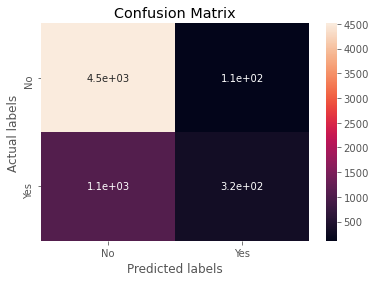

In [70]:
# Model 1: Logistic Regression Model

Log_Reg = LogisticRegression(penalty='l1', C=10000, solver='liblinear').fit(X_train_sc, y_train)
train_accuracy = round(Log_Reg.score(X_train_sc, y_train), 2)
test_accuracy = round(Log_Reg.score(X_test_sc, y_test), 2)

y_pred = Log_Reg.predict(X_test_sc)

labels = ['No', 'Yes']

print(classification_report(y_test, y_pred, target_names=labels))

print("Training Accuracy: ", train_accuracy)
print("Test Accuracy: ", test_accuracy)

# Confusion Matrix

y_pred_string=y_pred.astype(str)
y_pred_string[np.where(y_pred_string == '0')] = 'No'
y_pred_string[np.where(y_pred_string == '1')] = 'Yes'

# temp = y_test['default.payment.next.month'].to_numpy().T
y_test_string= y_test.astype (str)
y_test_string[np.where(y_test_string == '0')] = 'No'
y_test_string[np.where(y_test_string == '1')] = 'Yes'

ax = plt.subplot()
cm = confusion_matrix(y_test_string, y_pred_string) 
sns.heatmap(cm, annot=True, ax=ax); #annot-True to annotate cetts

# Labels, title and ticks

ax.set_xlabel("Predicted labels")
ax.set_ylabel("Actual labels")
ax.set_title("Confusion Matrix")
ax.xaxis.set_ticklabels(['No', 'Yes'])
ax.yaxis.set_ticklabels (['No', 'Yes'])
plt.show()

In [72]:
#Hyperparameter Tuning for Logistic Regression Model

from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import GridSearchCV

Log_Reg = LogisticRegression()

solvers = ["newton-cg", "Ibfgs", "liblinear"]
penalty = ['l1', 'l2']
c_values = [10000, 1000, 100, 1.0, 0.1, 0.01]

grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold (n_splits=18, n_repeats=3, random_state = RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid = grid, n_jobs=-1, cv=cv, scoring='precision', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.717798 using {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}


In [65]:
# Model 2: CatBoost Classification Model

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

CBC= cb.CatBoostClassifier(loss_function='Logloss', eval_metric='Accuracy')

grid = {'learning_rate': [0.03, 0.1], 
        'depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5,], 
        'iterations': [50, 100, 150]}
CBC.grid_search(grid, train_dataset)
CBC.get_params()
y_pred1 = CBC.predict(X_test_sc)

0:	learn: 0.8227604	test: 0.8164583	best: 0.8164583 (0)	total: 6.22ms	remaining: 305ms
1:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 11.6ms	remaining: 279ms
2:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 18.7ms	remaining: 294ms
3:	learn: 0.8213542	test: 0.8177083	best: 0.8177083 (1)	total: 25.8ms	remaining: 296ms
4:	learn: 0.8223438	test: 0.8168750	best: 0.8177083 (1)	total: 31.6ms	remaining: 284ms
5:	learn: 0.8214583	test: 0.8179167	best: 0.8179167 (5)	total: 38.4ms	remaining: 282ms
6:	learn: 0.8213021	test: 0.8177083	best: 0.8179167 (5)	total: 44.3ms	remaining: 272ms
7:	learn: 0.8213021	test: 0.8177083	best: 0.8179167 (5)	total: 49.8ms	remaining: 261ms
8:	learn: 0.8213021	test: 0.8177083	best: 0.8179167 (5)	total: 56.7ms	remaining: 258ms
9:	learn: 0.8217708	test: 0.8177083	best: 0.8179167 (5)	total: 63.5ms	remaining: 254ms
10:	learn: 0.8215625	test: 0.8177083	best: 0.8179167 (5)	total: 69.2ms	remaining: 245ms
11:	learn: 0.8214063	test: 0.8175000	best:

12:	learn: 0.8214063	test: 0.8181250	best: 0.8181250 (12)	total: 84.7ms	remaining: 241ms
13:	learn: 0.8213542	test: 0.8177083	best: 0.8181250 (12)	total: 91.1ms	remaining: 234ms
14:	learn: 0.8215104	test: 0.8179167	best: 0.8181250 (12)	total: 97.4ms	remaining: 227ms
15:	learn: 0.8215104	test: 0.8183333	best: 0.8183333 (15)	total: 105ms	remaining: 224ms
16:	learn: 0.8214583	test: 0.8177083	best: 0.8183333 (15)	total: 112ms	remaining: 218ms
17:	learn: 0.8214583	test: 0.8177083	best: 0.8183333 (15)	total: 119ms	remaining: 212ms
18:	learn: 0.8214583	test: 0.8177083	best: 0.8183333 (15)	total: 125ms	remaining: 204ms
19:	learn: 0.8214063	test: 0.8177083	best: 0.8183333 (15)	total: 132ms	remaining: 198ms
20:	learn: 0.8214583	test: 0.8177083	best: 0.8183333 (15)	total: 138ms	remaining: 191ms
21:	learn: 0.8213542	test: 0.8177083	best: 0.8183333 (15)	total: 145ms	remaining: 185ms
22:	learn: 0.8214583	test: 0.8177083	best: 0.8183333 (15)	total: 151ms	remaining: 178ms
23:	learn: 0.8214583	test: 0.

25:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 162ms	remaining: 149ms
26:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 169ms	remaining: 144ms
27:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 177ms	remaining: 139ms
28:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 184ms	remaining: 133ms
29:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 192ms	remaining: 128ms
30:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 199ms	remaining: 122ms
31:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 205ms	remaining: 115ms
32:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 211ms	remaining: 109ms
33:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 218ms	remaining: 103ms
34:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 224ms	remaining: 95.8ms
35:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 231ms	remaining: 89.6ms
36:	learn: 0.8213021	test: 0.8177083	best

38:	learn: 0.8216146	test: 0.8175000	best: 0.8179167 (5)	total: 248ms	remaining: 388ms
39:	learn: 0.8215104	test: 0.8179167	best: 0.8179167 (5)	total: 255ms	remaining: 382ms
40:	learn: 0.8215104	test: 0.8179167	best: 0.8179167 (5)	total: 262ms	remaining: 377ms
41:	learn: 0.8215104	test: 0.8179167	best: 0.8179167 (5)	total: 268ms	remaining: 370ms
42:	learn: 0.8214583	test: 0.8172917	best: 0.8179167 (5)	total: 274ms	remaining: 363ms
43:	learn: 0.8218229	test: 0.8177083	best: 0.8179167 (5)	total: 280ms	remaining: 357ms
44:	learn: 0.8222396	test: 0.8170833	best: 0.8179167 (5)	total: 286ms	remaining: 350ms
45:	learn: 0.8223958	test: 0.8172917	best: 0.8179167 (5)	total: 293ms	remaining: 344ms
46:	learn: 0.8218229	test: 0.8172917	best: 0.8179167 (5)	total: 298ms	remaining: 336ms
47:	learn: 0.8218229	test: 0.8170833	best: 0.8179167 (5)	total: 303ms	remaining: 329ms
48:	learn: 0.8222396	test: 0.8168750	best: 0.8179167 (5)	total: 309ms	remaining: 322ms
49:	learn: 0.8224479	test: 0.8175000	best: 

53:	learn: 0.8250521	test: 0.8160417	best: 0.8187500 (9)	total: 349ms	remaining: 297ms
54:	learn: 0.8251563	test: 0.8160417	best: 0.8187500 (9)	total: 359ms	remaining: 294ms
55:	learn: 0.8252083	test: 0.8158333	best: 0.8187500 (9)	total: 367ms	remaining: 288ms
56:	learn: 0.8251563	test: 0.8158333	best: 0.8187500 (9)	total: 374ms	remaining: 282ms
57:	learn: 0.8252604	test: 0.8160417	best: 0.8187500 (9)	total: 379ms	remaining: 275ms
58:	learn: 0.8251563	test: 0.8164583	best: 0.8187500 (9)	total: 386ms	remaining: 268ms
59:	learn: 0.8253125	test: 0.8164583	best: 0.8187500 (9)	total: 392ms	remaining: 261ms
60:	learn: 0.8251563	test: 0.8164583	best: 0.8187500 (9)	total: 397ms	remaining: 254ms
61:	learn: 0.8253125	test: 0.8162500	best: 0.8187500 (9)	total: 403ms	remaining: 247ms
62:	learn: 0.8252604	test: 0.8162500	best: 0.8187500 (9)	total: 409ms	remaining: 240ms
63:	learn: 0.8253125	test: 0.8162500	best: 0.8187500 (9)	total: 415ms	remaining: 233ms
64:	learn: 0.8255208	test: 0.8164583	best: 

65:	learn: 0.8236979	test: 0.8168750	best: 0.8187500 (56)	total: 423ms	remaining: 218ms
66:	learn: 0.8237500	test: 0.8166667	best: 0.8187500 (56)	total: 429ms	remaining: 211ms
67:	learn: 0.8238542	test: 0.8170833	best: 0.8187500 (56)	total: 436ms	remaining: 205ms
68:	learn: 0.8238542	test: 0.8170833	best: 0.8187500 (56)	total: 444ms	remaining: 199ms
69:	learn: 0.8238542	test: 0.8170833	best: 0.8187500 (56)	total: 450ms	remaining: 193ms
70:	learn: 0.8239583	test: 0.8170833	best: 0.8187500 (56)	total: 457ms	remaining: 187ms
71:	learn: 0.8240104	test: 0.8172917	best: 0.8187500 (56)	total: 462ms	remaining: 180ms
72:	learn: 0.8241667	test: 0.8172917	best: 0.8187500 (56)	total: 469ms	remaining: 174ms
73:	learn: 0.8240104	test: 0.8170833	best: 0.8187500 (56)	total: 476ms	remaining: 167ms
74:	learn: 0.8241146	test: 0.8172917	best: 0.8187500 (56)	total: 481ms	remaining: 160ms
75:	learn: 0.8241146	test: 0.8172917	best: 0.8187500 (56)	total: 488ms	remaining: 154ms
76:	learn: 0.8240104	test: 0.817

76:	learn: 0.8250000	test: 0.8160417	best: 0.8185417 (10)	total: 507ms	remaining: 151ms
77:	learn: 0.8250000	test: 0.8160417	best: 0.8185417 (10)	total: 514ms	remaining: 145ms
78:	learn: 0.8252083	test: 0.8158333	best: 0.8185417 (10)	total: 522ms	remaining: 139ms
79:	learn: 0.8253125	test: 0.8156250	best: 0.8185417 (10)	total: 530ms	remaining: 132ms
80:	learn: 0.8253646	test: 0.8158333	best: 0.8185417 (10)	total: 537ms	remaining: 126ms
81:	learn: 0.8253125	test: 0.8158333	best: 0.8185417 (10)	total: 544ms	remaining: 119ms
82:	learn: 0.8254167	test: 0.8158333	best: 0.8185417 (10)	total: 551ms	remaining: 113ms
83:	learn: 0.8254167	test: 0.8158333	best: 0.8185417 (10)	total: 558ms	remaining: 106ms
84:	learn: 0.8253646	test: 0.8156250	best: 0.8185417 (10)	total: 564ms	remaining: 99.6ms
85:	learn: 0.8253646	test: 0.8158333	best: 0.8185417 (10)	total: 570ms	remaining: 92.8ms
86:	learn: 0.8251042	test: 0.8158333	best: 0.8185417 (10)	total: 577ms	remaining: 86.1ms
87:	learn: 0.8251563	test: 0.

87:	learn: 0.8237500	test: 0.8172917	best: 0.8183333 (55)	total: 582ms	remaining: 79.3ms
88:	learn: 0.8236979	test: 0.8175000	best: 0.8183333 (55)	total: 589ms	remaining: 72.8ms
89:	learn: 0.8236979	test: 0.8175000	best: 0.8183333 (55)	total: 597ms	remaining: 66.3ms
90:	learn: 0.8236458	test: 0.8170833	best: 0.8183333 (55)	total: 604ms	remaining: 59.7ms
91:	learn: 0.8236458	test: 0.8170833	best: 0.8183333 (55)	total: 611ms	remaining: 53.1ms
92:	learn: 0.8236979	test: 0.8172917	best: 0.8183333 (55)	total: 617ms	remaining: 46.4ms
93:	learn: 0.8236458	test: 0.8170833	best: 0.8183333 (55)	total: 623ms	remaining: 39.8ms
94:	learn: 0.8235938	test: 0.8168750	best: 0.8183333 (55)	total: 629ms	remaining: 33.1ms
95:	learn: 0.8234375	test: 0.8168750	best: 0.8183333 (55)	total: 636ms	remaining: 26.5ms
96:	learn: 0.8235417	test: 0.8168750	best: 0.8183333 (55)	total: 643ms	remaining: 19.9ms
97:	learn: 0.8235417	test: 0.8168750	best: 0.8183333 (55)	total: 649ms	remaining: 13.3ms
98:	learn: 0.8235417	

95:	learn: 0.8261458	test: 0.8164583	best: 0.8183333 (7)	total: 657ms	remaining: 27.4ms
96:	learn: 0.8260417	test: 0.8164583	best: 0.8183333 (7)	total: 664ms	remaining: 20.5ms
97:	learn: 0.8261979	test: 0.8166667	best: 0.8183333 (7)	total: 672ms	remaining: 13.7ms
98:	learn: 0.8262500	test: 0.8164583	best: 0.8183333 (7)	total: 678ms	remaining: 6.85ms
99:	learn: 0.8263021	test: 0.8162500	best: 0.8183333 (7)	total: 685ms	remaining: 0us

bestTest = 0.8183333333
bestIteration = 7

11:	loss: 0.8183333	best: 0.8187500 (1)	total: 6.59s	remaining: 23.1s
0:	learn: 0.8227604	test: 0.8164583	best: 0.8164583 (0)	total: 6.48ms	remaining: 966ms
1:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 12ms	remaining: 885ms
2:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 18.7ms	remaining: 914ms
3:	learn: 0.8213542	test: 0.8177083	best: 0.8177083 (1)	total: 25.3ms	remaining: 924ms
4:	learn: 0.8223438	test: 0.8168750	best: 0.8177083 (1)	total: 31.1ms	remaining: 902ms
5:	learn: 0.8214

110:	learn: 0.8238021	test: 0.8166667	best: 0.8181250 (57)	total: 712ms	remaining: 250ms
111:	learn: 0.8238542	test: 0.8168750	best: 0.8181250 (57)	total: 719ms	remaining: 244ms
112:	learn: 0.8238542	test: 0.8168750	best: 0.8181250 (57)	total: 728ms	remaining: 238ms
113:	learn: 0.8238021	test: 0.8166667	best: 0.8181250 (57)	total: 735ms	remaining: 232ms
114:	learn: 0.8236979	test: 0.8164583	best: 0.8181250 (57)	total: 742ms	remaining: 226ms
115:	learn: 0.8237500	test: 0.8166667	best: 0.8181250 (57)	total: 749ms	remaining: 219ms
116:	learn: 0.8237500	test: 0.8166667	best: 0.8181250 (57)	total: 756ms	remaining: 213ms
117:	learn: 0.8237500	test: 0.8166667	best: 0.8181250 (57)	total: 761ms	remaining: 206ms
118:	learn: 0.8238021	test: 0.8166667	best: 0.8181250 (57)	total: 768ms	remaining: 200ms
119:	learn: 0.8238021	test: 0.8166667	best: 0.8181250 (57)	total: 775ms	remaining: 194ms
120:	learn: 0.8238542	test: 0.8166667	best: 0.8181250 (57)	total: 782ms	remaining: 187ms
121:	learn: 0.8238542

74:	learn: 0.8254687	test: 0.8147917	best: 0.8187500 (9)	total: 487ms	remaining: 487ms
75:	learn: 0.8256771	test: 0.8152083	best: 0.8187500 (9)	total: 494ms	remaining: 481ms
76:	learn: 0.8256771	test: 0.8152083	best: 0.8187500 (9)	total: 502ms	remaining: 475ms
77:	learn: 0.8258333	test: 0.8156250	best: 0.8187500 (9)	total: 508ms	remaining: 469ms
78:	learn: 0.8258333	test: 0.8156250	best: 0.8187500 (9)	total: 516ms	remaining: 463ms
79:	learn: 0.8258333	test: 0.8154167	best: 0.8187500 (9)	total: 523ms	remaining: 457ms
80:	learn: 0.8257813	test: 0.8154167	best: 0.8187500 (9)	total: 530ms	remaining: 451ms
81:	learn: 0.8257813	test: 0.8154167	best: 0.8187500 (9)	total: 536ms	remaining: 445ms
82:	learn: 0.8257813	test: 0.8154167	best: 0.8187500 (9)	total: 543ms	remaining: 439ms
83:	learn: 0.8258333	test: 0.8154167	best: 0.8187500 (9)	total: 550ms	remaining: 432ms
84:	learn: 0.8258333	test: 0.8154167	best: 0.8187500 (9)	total: 557ms	remaining: 426ms
85:	learn: 0.8258333	test: 0.8152083	best: 

33:	learn: 0.8221875	test: 0.8179167	best: 0.8183333 (15)	total: 223ms	remaining: 762ms
34:	learn: 0.8222396	test: 0.8179167	best: 0.8183333 (15)	total: 230ms	remaining: 757ms
35:	learn: 0.8224479	test: 0.8177083	best: 0.8183333 (15)	total: 236ms	remaining: 749ms
36:	learn: 0.8225521	test: 0.8177083	best: 0.8183333 (15)	total: 243ms	remaining: 742ms
37:	learn: 0.8219792	test: 0.8179167	best: 0.8183333 (15)	total: 250ms	remaining: 736ms
38:	learn: 0.8219792	test: 0.8179167	best: 0.8183333 (15)	total: 256ms	remaining: 727ms
39:	learn: 0.8223438	test: 0.8177083	best: 0.8183333 (15)	total: 263ms	remaining: 724ms
40:	learn: 0.8222917	test: 0.8177083	best: 0.8183333 (15)	total: 269ms	remaining: 715ms
41:	learn: 0.8218750	test: 0.8179167	best: 0.8183333 (15)	total: 276ms	remaining: 710ms
42:	learn: 0.8220312	test: 0.8177083	best: 0.8183333 (15)	total: 282ms	remaining: 701ms
43:	learn: 0.8221354	test: 0.8179167	best: 0.8183333 (15)	total: 289ms	remaining: 695ms
44:	learn: 0.8222917	test: 0.818

143:	learn: 0.8243229	test: 0.8164583	best: 0.8187500 (56)	total: 962ms	remaining: 40.1ms
144:	learn: 0.8242708	test: 0.8162500	best: 0.8187500 (56)	total: 970ms	remaining: 33.4ms
145:	learn: 0.8243229	test: 0.8162500	best: 0.8187500 (56)	total: 977ms	remaining: 26.8ms
146:	learn: 0.8243750	test: 0.8164583	best: 0.8187500 (56)	total: 984ms	remaining: 20.1ms
147:	learn: 0.8244792	test: 0.8164583	best: 0.8187500 (56)	total: 992ms	remaining: 13.4ms
148:	learn: 0.8245313	test: 0.8164583	best: 0.8187500 (56)	total: 999ms	remaining: 6.71ms
149:	learn: 0.8243750	test: 0.8164583	best: 0.8187500 (56)	total: 1s	remaining: 0us

bestTest = 0.81875
bestIteration = 56

14:	loss: 0.8187500	best: 0.8187500 (1)	total: 9.62s	remaining: 25s
0:	learn: 0.8227604	test: 0.8164583	best: 0.8164583 (0)	total: 5.83ms	remaining: 869ms
1:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 13.1ms	remaining: 967ms
2:	learn: 0.8213021	test: 0.8177083	best: 0.8177083 (1)	total: 19.1ms	remaining: 935ms
3:	lear

95:	learn: 0.8255729	test: 0.8150000	best: 0.8185417 (10)	total: 696ms	remaining: 391ms
96:	learn: 0.8254687	test: 0.8150000	best: 0.8185417 (10)	total: 703ms	remaining: 384ms
97:	learn: 0.8256250	test: 0.8150000	best: 0.8185417 (10)	total: 710ms	remaining: 377ms
98:	learn: 0.8253646	test: 0.8150000	best: 0.8185417 (10)	total: 717ms	remaining: 369ms
99:	learn: 0.8254167	test: 0.8152083	best: 0.8185417 (10)	total: 724ms	remaining: 362ms
100:	learn: 0.8254167	test: 0.8150000	best: 0.8185417 (10)	total: 732ms	remaining: 355ms
101:	learn: 0.8255208	test: 0.8152083	best: 0.8185417 (10)	total: 742ms	remaining: 349ms
102:	learn: 0.8256250	test: 0.8152083	best: 0.8185417 (10)	total: 749ms	remaining: 342ms
103:	learn: 0.8255208	test: 0.8154167	best: 0.8185417 (10)	total: 757ms	remaining: 335ms
104:	learn: 0.8254687	test: 0.8152083	best: 0.8185417 (10)	total: 765ms	remaining: 328ms
105:	learn: 0.8255208	test: 0.8152083	best: 0.8185417 (10)	total: 772ms	remaining: 320ms
106:	learn: 0.8255208	test

51:	learn: 0.8225521	test: 0.8181250	best: 0.8181250 (40)	total: 344ms	remaining: 648ms
52:	learn: 0.8227083	test: 0.8181250	best: 0.8181250 (40)	total: 352ms	remaining: 644ms
53:	learn: 0.8231771	test: 0.8177083	best: 0.8181250 (40)	total: 360ms	remaining: 640ms
54:	learn: 0.8227083	test: 0.8179167	best: 0.8181250 (40)	total: 367ms	remaining: 634ms
55:	learn: 0.8233333	test: 0.8183333	best: 0.8183333 (55)	total: 377ms	remaining: 632ms
56:	learn: 0.8232812	test: 0.8181250	best: 0.8183333 (55)	total: 385ms	remaining: 629ms
57:	learn: 0.8232812	test: 0.8177083	best: 0.8183333 (55)	total: 394ms	remaining: 624ms
58:	learn: 0.8232812	test: 0.8170833	best: 0.8183333 (55)	total: 400ms	remaining: 616ms
59:	learn: 0.8234375	test: 0.8170833	best: 0.8183333 (55)	total: 406ms	remaining: 609ms
60:	learn: 0.8233854	test: 0.8177083	best: 0.8183333 (55)	total: 413ms	remaining: 602ms
61:	learn: 0.8236458	test: 0.8172917	best: 0.8183333 (55)	total: 421ms	remaining: 597ms
62:	learn: 0.8235417	test: 0.817

3:	learn: 0.8215625	test: 0.8177083	best: 0.8177083 (3)	total: 26.7ms	remaining: 976ms
4:	learn: 0.8235417	test: 0.8170833	best: 0.8177083 (3)	total: 34.1ms	remaining: 988ms
5:	learn: 0.8230208	test: 0.8168750	best: 0.8177083 (3)	total: 41.5ms	remaining: 996ms
6:	learn: 0.8232292	test: 0.8181250	best: 0.8181250 (6)	total: 47.8ms	remaining: 976ms
7:	learn: 0.8214063	test: 0.8183333	best: 0.8183333 (7)	total: 55.5ms	remaining: 985ms
8:	learn: 0.8216667	test: 0.8179167	best: 0.8183333 (7)	total: 62ms	remaining: 971ms
9:	learn: 0.8216146	test: 0.8177083	best: 0.8183333 (7)	total: 68.8ms	remaining: 964ms
10:	learn: 0.8219271	test: 0.8181250	best: 0.8183333 (7)	total: 75.6ms	remaining: 955ms
11:	learn: 0.8231250	test: 0.8172917	best: 0.8183333 (7)	total: 81.1ms	remaining: 932ms
12:	learn: 0.8231771	test: 0.8172917	best: 0.8183333 (7)	total: 87.9ms	remaining: 927ms
13:	learn: 0.8231250	test: 0.8179167	best: 0.8183333 (7)	total: 93.6ms	remaining: 909ms
14:	learn: 0.8232292	test: 0.8175000	best

106:	learn: 0.8264063	test: 0.8160417	best: 0.8183333 (7)	total: 761ms	remaining: 306ms
107:	learn: 0.8265104	test: 0.8158333	best: 0.8183333 (7)	total: 769ms	remaining: 299ms
108:	learn: 0.8266146	test: 0.8156250	best: 0.8183333 (7)	total: 777ms	remaining: 292ms
109:	learn: 0.8266146	test: 0.8156250	best: 0.8183333 (7)	total: 783ms	remaining: 285ms
110:	learn: 0.8267187	test: 0.8158333	best: 0.8183333 (7)	total: 791ms	remaining: 278ms
111:	learn: 0.8266667	test: 0.8158333	best: 0.8183333 (7)	total: 798ms	remaining: 271ms
112:	learn: 0.8267708	test: 0.8158333	best: 0.8183333 (7)	total: 804ms	remaining: 263ms
113:	learn: 0.8266667	test: 0.8160417	best: 0.8183333 (7)	total: 811ms	remaining: 256ms
114:	learn: 0.8265625	test: 0.8162500	best: 0.8183333 (7)	total: 818ms	remaining: 249ms
115:	learn: 0.8266667	test: 0.8156250	best: 0.8183333 (7)	total: 825ms	remaining: 242ms
116:	learn: 0.8270312	test: 0.8156250	best: 0.8183333 (7)	total: 832ms	remaining: 235ms
117:	learn: 0.8270833	test: 0.81

6:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 57.6ms	remaining: 354ms
7:	learn: 0.8219792	test: 0.8168750	best: 0.8175000 (2)	total: 63.3ms	remaining: 333ms
8:	learn: 0.8224479	test: 0.8170833	best: 0.8175000 (2)	total: 74ms	remaining: 337ms
9:	learn: 0.8227604	test: 0.8166667	best: 0.8175000 (2)	total: 82.9ms	remaining: 332ms
10:	learn: 0.8234375	test: 0.8170833	best: 0.8175000 (2)	total: 91.3ms	remaining: 324ms
11:	learn: 0.8235938	test: 0.8168750	best: 0.8175000 (2)	total: 99.8ms	remaining: 316ms
12:	learn: 0.8239062	test: 0.8172917	best: 0.8175000 (2)	total: 109ms	remaining: 309ms
13:	learn: 0.8239583	test: 0.8166667	best: 0.8175000 (2)	total: 117ms	remaining: 301ms
14:	learn: 0.8240625	test: 0.8164583	best: 0.8175000 (2)	total: 126ms	remaining: 294ms
15:	learn: 0.8240104	test: 0.8168750	best: 0.8175000 (2)	total: 135ms	remaining: 287ms
16:	learn: 0.8242188	test: 0.8166667	best: 0.8175000 (2)	total: 143ms	remaining: 278ms
17:	learn: 0.8244792	test: 0.8162500	best: 

16:	learn: 0.8238021	test: 0.8168750	best: 0.8175000 (2)	total: 158ms	remaining: 306ms
17:	learn: 0.8240104	test: 0.8168750	best: 0.8175000 (2)	total: 167ms	remaining: 297ms
18:	learn: 0.8245313	test: 0.8168750	best: 0.8175000 (2)	total: 177ms	remaining: 289ms
19:	learn: 0.8246875	test: 0.8164583	best: 0.8175000 (2)	total: 187ms	remaining: 280ms
20:	learn: 0.8243750	test: 0.8164583	best: 0.8175000 (2)	total: 195ms	remaining: 269ms
21:	learn: 0.8246875	test: 0.8164583	best: 0.8175000 (2)	total: 204ms	remaining: 260ms
22:	learn: 0.8245833	test: 0.8158333	best: 0.8175000 (2)	total: 213ms	remaining: 250ms
23:	learn: 0.8249479	test: 0.8154167	best: 0.8175000 (2)	total: 222ms	remaining: 240ms
24:	learn: 0.8250000	test: 0.8158333	best: 0.8175000 (2)	total: 231ms	remaining: 231ms
25:	learn: 0.8251042	test: 0.8154167	best: 0.8175000 (2)	total: 240ms	remaining: 222ms
26:	learn: 0.8252604	test: 0.8158333	best: 0.8175000 (2)	total: 249ms	remaining: 212ms
27:	learn: 0.8254167	test: 0.8158333	best: 

19:	learn: 0.8247917	test: 0.8166667	best: 0.8175000 (2)	total: 199ms	remaining: 299ms
20:	learn: 0.8248437	test: 0.8162500	best: 0.8175000 (2)	total: 210ms	remaining: 289ms
21:	learn: 0.8251042	test: 0.8158333	best: 0.8175000 (2)	total: 221ms	remaining: 281ms
22:	learn: 0.8249479	test: 0.8160417	best: 0.8175000 (2)	total: 231ms	remaining: 271ms
23:	learn: 0.8248437	test: 0.8158333	best: 0.8175000 (2)	total: 241ms	remaining: 261ms
24:	learn: 0.8252083	test: 0.8160417	best: 0.8175000 (2)	total: 250ms	remaining: 250ms
25:	learn: 0.8252604	test: 0.8156250	best: 0.8175000 (2)	total: 260ms	remaining: 240ms
26:	learn: 0.8251563	test: 0.8156250	best: 0.8175000 (2)	total: 270ms	remaining: 230ms
27:	learn: 0.8250521	test: 0.8156250	best: 0.8175000 (2)	total: 280ms	remaining: 220ms
28:	learn: 0.8255208	test: 0.8152083	best: 0.8175000 (2)	total: 289ms	remaining: 210ms
29:	learn: 0.8254167	test: 0.8158333	best: 0.8175000 (2)	total: 300ms	remaining: 200ms
30:	learn: 0.8253125	test: 0.8158333	best: 

67:	learn: 0.8253646	test: 0.8168750	best: 0.8177083 (4)	total: 656ms	remaining: 309ms
68:	learn: 0.8253125	test: 0.8170833	best: 0.8177083 (4)	total: 665ms	remaining: 299ms
69:	learn: 0.8252083	test: 0.8166667	best: 0.8177083 (4)	total: 675ms	remaining: 289ms
70:	learn: 0.8251563	test: 0.8164583	best: 0.8177083 (4)	total: 685ms	remaining: 280ms
71:	learn: 0.8251563	test: 0.8166667	best: 0.8177083 (4)	total: 695ms	remaining: 270ms
72:	learn: 0.8252083	test: 0.8168750	best: 0.8177083 (4)	total: 705ms	remaining: 261ms
73:	learn: 0.8251563	test: 0.8172917	best: 0.8177083 (4)	total: 718ms	remaining: 252ms
74:	learn: 0.8254167	test: 0.8172917	best: 0.8177083 (4)	total: 728ms	remaining: 243ms
75:	learn: 0.8255729	test: 0.8172917	best: 0.8177083 (4)	total: 740ms	remaining: 234ms
76:	learn: 0.8254687	test: 0.8170833	best: 0.8177083 (4)	total: 762ms	remaining: 227ms
77:	learn: 0.8255208	test: 0.8172917	best: 0.8177083 (4)	total: 774ms	remaining: 218ms
78:	learn: 0.8255729	test: 0.8170833	best: 

62:	learn: 0.8284896	test: 0.8147917	best: 0.8177083 (26)	total: 619ms	remaining: 364ms
63:	learn: 0.8284375	test: 0.8147917	best: 0.8177083 (26)	total: 630ms	remaining: 354ms
64:	learn: 0.8283333	test: 0.8154167	best: 0.8177083 (26)	total: 640ms	remaining: 345ms
65:	learn: 0.8286458	test: 0.8154167	best: 0.8177083 (26)	total: 651ms	remaining: 335ms
66:	learn: 0.8284896	test: 0.8154167	best: 0.8177083 (26)	total: 662ms	remaining: 326ms
67:	learn: 0.8285938	test: 0.8154167	best: 0.8177083 (26)	total: 672ms	remaining: 316ms
68:	learn: 0.8286458	test: 0.8154167	best: 0.8177083 (26)	total: 682ms	remaining: 306ms
69:	learn: 0.8287500	test: 0.8154167	best: 0.8177083 (26)	total: 692ms	remaining: 297ms
70:	learn: 0.8288542	test: 0.8154167	best: 0.8177083 (26)	total: 702ms	remaining: 287ms
71:	learn: 0.8288542	test: 0.8152083	best: 0.8177083 (26)	total: 712ms	remaining: 277ms
72:	learn: 0.8287500	test: 0.8150000	best: 0.8177083 (26)	total: 722ms	remaining: 267ms
73:	learn: 0.8288542	test: 0.815

58:	learn: 0.8242708	test: 0.8172917	best: 0.8189583 (29)	total: 553ms	remaining: 384ms
59:	learn: 0.8247396	test: 0.8175000	best: 0.8189583 (29)	total: 562ms	remaining: 374ms
60:	learn: 0.8246875	test: 0.8170833	best: 0.8189583 (29)	total: 571ms	remaining: 365ms
61:	learn: 0.8248958	test: 0.8166667	best: 0.8189583 (29)	total: 581ms	remaining: 356ms
62:	learn: 0.8251042	test: 0.8168750	best: 0.8189583 (29)	total: 590ms	remaining: 347ms
63:	learn: 0.8248958	test: 0.8164583	best: 0.8189583 (29)	total: 601ms	remaining: 338ms
64:	learn: 0.8251042	test: 0.8162500	best: 0.8189583 (29)	total: 610ms	remaining: 329ms
65:	learn: 0.8248437	test: 0.8162500	best: 0.8189583 (29)	total: 617ms	remaining: 318ms
66:	learn: 0.8247917	test: 0.8166667	best: 0.8189583 (29)	total: 626ms	remaining: 309ms
67:	learn: 0.8248958	test: 0.8164583	best: 0.8189583 (29)	total: 636ms	remaining: 299ms
68:	learn: 0.8248437	test: 0.8162500	best: 0.8189583 (29)	total: 646ms	remaining: 290ms
69:	learn: 0.8249479	test: 0.816

55:	learn: 0.8271875	test: 0.8154167	best: 0.8175000 (2)	total: 545ms	remaining: 428ms
56:	learn: 0.8275521	test: 0.8147917	best: 0.8175000 (2)	total: 554ms	remaining: 418ms
57:	learn: 0.8276042	test: 0.8145833	best: 0.8175000 (2)	total: 564ms	remaining: 408ms
58:	learn: 0.8276562	test: 0.8145833	best: 0.8175000 (2)	total: 573ms	remaining: 398ms
59:	learn: 0.8278125	test: 0.8147917	best: 0.8175000 (2)	total: 582ms	remaining: 388ms
60:	learn: 0.8278646	test: 0.8152083	best: 0.8175000 (2)	total: 592ms	remaining: 378ms
61:	learn: 0.8279688	test: 0.8150000	best: 0.8175000 (2)	total: 601ms	remaining: 369ms
62:	learn: 0.8279688	test: 0.8147917	best: 0.8175000 (2)	total: 610ms	remaining: 358ms
63:	learn: 0.8280208	test: 0.8147917	best: 0.8175000 (2)	total: 620ms	remaining: 349ms
64:	learn: 0.8279688	test: 0.8141667	best: 0.8175000 (2)	total: 629ms	remaining: 339ms
65:	learn: 0.8280208	test: 0.8141667	best: 0.8175000 (2)	total: 638ms	remaining: 329ms
66:	learn: 0.8280729	test: 0.8141667	best: 

50:	learn: 0.8237500	test: 0.8162500	best: 0.8183333 (3)	total: 497ms	remaining: 477ms
51:	learn: 0.8236979	test: 0.8162500	best: 0.8183333 (3)	total: 506ms	remaining: 468ms
52:	learn: 0.8238542	test: 0.8164583	best: 0.8183333 (3)	total: 517ms	remaining: 458ms
53:	learn: 0.8239062	test: 0.8166667	best: 0.8183333 (3)	total: 526ms	remaining: 448ms
54:	learn: 0.8240625	test: 0.8168750	best: 0.8183333 (3)	total: 537ms	remaining: 439ms
55:	learn: 0.8240104	test: 0.8168750	best: 0.8183333 (3)	total: 546ms	remaining: 429ms
56:	learn: 0.8243229	test: 0.8168750	best: 0.8183333 (3)	total: 556ms	remaining: 419ms
57:	learn: 0.8243229	test: 0.8168750	best: 0.8183333 (3)	total: 565ms	remaining: 409ms
58:	learn: 0.8243750	test: 0.8166667	best: 0.8183333 (3)	total: 575ms	remaining: 400ms
59:	learn: 0.8244271	test: 0.8162500	best: 0.8183333 (3)	total: 585ms	remaining: 390ms
60:	learn: 0.8247917	test: 0.8164583	best: 0.8183333 (3)	total: 594ms	remaining: 380ms
61:	learn: 0.8246354	test: 0.8162500	best: 

48:	learn: 0.8265104	test: 0.8150000	best: 0.8175000 (2)	total: 517ms	remaining: 539ms
49:	learn: 0.8266146	test: 0.8150000	best: 0.8175000 (2)	total: 530ms	remaining: 530ms
50:	learn: 0.8266146	test: 0.8152083	best: 0.8175000 (2)	total: 555ms	remaining: 533ms
51:	learn: 0.8267187	test: 0.8150000	best: 0.8175000 (2)	total: 566ms	remaining: 522ms
52:	learn: 0.8268229	test: 0.8150000	best: 0.8175000 (2)	total: 579ms	remaining: 513ms
53:	learn: 0.8268229	test: 0.8152083	best: 0.8175000 (2)	total: 601ms	remaining: 512ms
54:	learn: 0.8271875	test: 0.8152083	best: 0.8175000 (2)	total: 613ms	remaining: 501ms
55:	learn: 0.8271875	test: 0.8152083	best: 0.8175000 (2)	total: 623ms	remaining: 490ms
56:	learn: 0.8271354	test: 0.8150000	best: 0.8175000 (2)	total: 638ms	remaining: 481ms
57:	learn: 0.8272396	test: 0.8150000	best: 0.8175000 (2)	total: 650ms	remaining: 470ms
58:	learn: 0.8272396	test: 0.8152083	best: 0.8175000 (2)	total: 661ms	remaining: 459ms
59:	learn: 0.8273958	test: 0.8152083	best: 

45:	learn: 0.8244792	test: 0.8170833	best: 0.8177083 (4)	total: 541ms	remaining: 1.22s
46:	learn: 0.8245833	test: 0.8172917	best: 0.8177083 (4)	total: 552ms	remaining: 1.21s
47:	learn: 0.8245313	test: 0.8177083	best: 0.8177083 (4)	total: 562ms	remaining: 1.19s
48:	learn: 0.8244792	test: 0.8175000	best: 0.8177083 (4)	total: 575ms	remaining: 1.18s
49:	learn: 0.8243750	test: 0.8172917	best: 0.8177083 (4)	total: 585ms	remaining: 1.17s
50:	learn: 0.8245313	test: 0.8172917	best: 0.8177083 (4)	total: 595ms	remaining: 1.15s
51:	learn: 0.8244271	test: 0.8177083	best: 0.8177083 (4)	total: 607ms	remaining: 1.14s
52:	learn: 0.8243229	test: 0.8170833	best: 0.8177083 (4)	total: 626ms	remaining: 1.15s
53:	learn: 0.8244271	test: 0.8170833	best: 0.8177083 (4)	total: 637ms	remaining: 1.13s
54:	learn: 0.8245313	test: 0.8168750	best: 0.8177083 (4)	total: 647ms	remaining: 1.12s
55:	learn: 0.8244792	test: 0.8168750	best: 0.8177083 (4)	total: 655ms	remaining: 1.1s
56:	learn: 0.8249479	test: 0.8170833	best: 0

146:	learn: 0.8276562	test: 0.8154167	best: 0.8177083 (4)	total: 1.51s	remaining: 30.8ms
147:	learn: 0.8275000	test: 0.8152083	best: 0.8177083 (4)	total: 1.52s	remaining: 20.6ms
148:	learn: 0.8275000	test: 0.8152083	best: 0.8177083 (4)	total: 1.53s	remaining: 10.3ms
149:	learn: 0.8275000	test: 0.8152083	best: 0.8177083 (4)	total: 1.54s	remaining: 0us

bestTest = 0.8177083333
bestIteration = 4

30:	loss: 0.8177083	best: 0.8189583 (20)	total: 23.4s	remaining: 17.3s
0:	learn: 0.8235938	test: 0.8172917	best: 0.8172917 (0)	total: 9.4ms	remaining: 1.4s
1:	learn: 0.8223438	test: 0.8160417	best: 0.8172917 (0)	total: 24.1ms	remaining: 1.78s
2:	learn: 0.8236458	test: 0.8175000	best: 0.8175000 (2)	total: 33.3ms	remaining: 1.63s
3:	learn: 0.8223958	test: 0.8172917	best: 0.8175000 (2)	total: 43.1ms	remaining: 1.57s
4:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 52.6ms	remaining: 1.52s
5:	learn: 0.8219792	test: 0.8172917	best: 0.8175000 (2)	total: 65.4ms	remaining: 1.57s
6:	learn: 0.

93:	learn: 0.8307292	test: 0.8147917	best: 0.8177083 (26)	total: 959ms	remaining: 571ms
94:	learn: 0.8306771	test: 0.8145833	best: 0.8177083 (26)	total: 969ms	remaining: 561ms
95:	learn: 0.8308333	test: 0.8143750	best: 0.8177083 (26)	total: 979ms	remaining: 551ms
96:	learn: 0.8307813	test: 0.8139583	best: 0.8177083 (26)	total: 990ms	remaining: 541ms
97:	learn: 0.8307813	test: 0.8139583	best: 0.8177083 (26)	total: 999ms	remaining: 530ms
98:	learn: 0.8310417	test: 0.8139583	best: 0.8177083 (26)	total: 1.01s	remaining: 520ms
99:	learn: 0.8311458	test: 0.8139583	best: 0.8177083 (26)	total: 1.02s	remaining: 509ms
100:	learn: 0.8311458	test: 0.8137500	best: 0.8177083 (26)	total: 1.03s	remaining: 498ms
101:	learn: 0.8314583	test: 0.8135417	best: 0.8177083 (26)	total: 1.04s	remaining: 488ms
102:	learn: 0.8313542	test: 0.8137500	best: 0.8177083 (26)	total: 1.05s	remaining: 480ms
103:	learn: 0.8314583	test: 0.8139583	best: 0.8177083 (26)	total: 1.06s	remaining: 469ms
104:	learn: 0.8314583	test: 

45:	learn: 0.8250000	test: 0.8179167	best: 0.8189583 (29)	total: 434ms	remaining: 980ms
46:	learn: 0.8246354	test: 0.8175000	best: 0.8189583 (29)	total: 443ms	remaining: 971ms
47:	learn: 0.8246875	test: 0.8175000	best: 0.8189583 (29)	total: 452ms	remaining: 961ms
48:	learn: 0.8246875	test: 0.8179167	best: 0.8189583 (29)	total: 461ms	remaining: 951ms
49:	learn: 0.8245313	test: 0.8172917	best: 0.8189583 (29)	total: 470ms	remaining: 940ms
50:	learn: 0.8247396	test: 0.8172917	best: 0.8189583 (29)	total: 479ms	remaining: 931ms
51:	learn: 0.8247917	test: 0.8172917	best: 0.8189583 (29)	total: 489ms	remaining: 921ms
52:	learn: 0.8248437	test: 0.8172917	best: 0.8189583 (29)	total: 498ms	remaining: 911ms
53:	learn: 0.8241667	test: 0.8172917	best: 0.8189583 (29)	total: 507ms	remaining: 901ms
54:	learn: 0.8242188	test: 0.8170833	best: 0.8189583 (29)	total: 516ms	remaining: 892ms
55:	learn: 0.8242708	test: 0.8172917	best: 0.8189583 (29)	total: 526ms	remaining: 883ms
56:	learn: 0.8242188	test: 0.817

1:	learn: 0.8222917	test: 0.8160417	best: 0.8172917 (0)	total: 19.3ms	remaining: 1.43s
2:	learn: 0.8236458	test: 0.8175000	best: 0.8175000 (2)	total: 29.1ms	remaining: 1.43s
3:	learn: 0.8223438	test: 0.8172917	best: 0.8175000 (2)	total: 38.5ms	remaining: 1.4s
4:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 47.7ms	remaining: 1.38s
5:	learn: 0.8219792	test: 0.8172917	best: 0.8175000 (2)	total: 57ms	remaining: 1.37s
6:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 66.1ms	remaining: 1.35s
7:	learn: 0.8219792	test: 0.8168750	best: 0.8175000 (2)	total: 72ms	remaining: 1.28s
8:	learn: 0.8225521	test: 0.8172917	best: 0.8175000 (2)	total: 81.3ms	remaining: 1.27s
9:	learn: 0.8226042	test: 0.8172917	best: 0.8175000 (2)	total: 86.9ms	remaining: 1.22s
10:	learn: 0.8233333	test: 0.8166667	best: 0.8175000 (2)	total: 98ms	remaining: 1.24s
11:	learn: 0.8230208	test: 0.8168750	best: 0.8175000 (2)	total: 109ms	remaining: 1.25s
12:	learn: 0.8229688	test: 0.8170833	best: 0.8175

109:	learn: 0.8305208	test: 0.8137500	best: 0.8175000 (2)	total: 1.14s	remaining: 415ms
110:	learn: 0.8304687	test: 0.8137500	best: 0.8175000 (2)	total: 1.15s	remaining: 405ms
111:	learn: 0.8305208	test: 0.8137500	best: 0.8175000 (2)	total: 1.16s	remaining: 395ms
112:	learn: 0.8304687	test: 0.8137500	best: 0.8175000 (2)	total: 1.17s	remaining: 384ms
113:	learn: 0.8304167	test: 0.8135417	best: 0.8175000 (2)	total: 1.18s	remaining: 373ms
114:	learn: 0.8304687	test: 0.8133333	best: 0.8175000 (2)	total: 1.19s	remaining: 363ms
115:	learn: 0.8305729	test: 0.8137500	best: 0.8175000 (2)	total: 1.2s	remaining: 353ms
116:	learn: 0.8306771	test: 0.8137500	best: 0.8175000 (2)	total: 1.21s	remaining: 342ms
117:	learn: 0.8307292	test: 0.8141667	best: 0.8175000 (2)	total: 1.22s	remaining: 332ms
118:	learn: 0.8306771	test: 0.8137500	best: 0.8175000 (2)	total: 1.23s	remaining: 321ms
119:	learn: 0.8307292	test: 0.8135417	best: 0.8175000 (2)	total: 1.25s	remaining: 311ms
120:	learn: 0.8304687	test: 0.813

54:	learn: 0.8240625	test: 0.8168750	best: 0.8183333 (3)	total: 546ms	remaining: 943ms
55:	learn: 0.8240104	test: 0.8168750	best: 0.8183333 (3)	total: 555ms	remaining: 932ms
56:	learn: 0.8243229	test: 0.8168750	best: 0.8183333 (3)	total: 565ms	remaining: 922ms
57:	learn: 0.8243229	test: 0.8168750	best: 0.8183333 (3)	total: 575ms	remaining: 913ms
58:	learn: 0.8243750	test: 0.8166667	best: 0.8183333 (3)	total: 583ms	remaining: 900ms
59:	learn: 0.8244271	test: 0.8162500	best: 0.8183333 (3)	total: 593ms	remaining: 889ms
60:	learn: 0.8247917	test: 0.8164583	best: 0.8183333 (3)	total: 603ms	remaining: 879ms
61:	learn: 0.8246354	test: 0.8162500	best: 0.8183333 (3)	total: 614ms	remaining: 871ms
62:	learn: 0.8245313	test: 0.8162500	best: 0.8183333 (3)	total: 623ms	remaining: 861ms
63:	learn: 0.8244792	test: 0.8162500	best: 0.8183333 (3)	total: 632ms	remaining: 849ms
64:	learn: 0.8246875	test: 0.8164583	best: 0.8183333 (3)	total: 637ms	remaining: 833ms
65:	learn: 0.8247396	test: 0.8164583	best: 

4:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 48.5ms	remaining: 1.41s
5:	learn: 0.8219792	test: 0.8172917	best: 0.8175000 (2)	total: 57.6ms	remaining: 1.38s
6:	learn: 0.8216667	test: 0.8172917	best: 0.8175000 (2)	total: 66.5ms	remaining: 1.36s
7:	learn: 0.8219792	test: 0.8168750	best: 0.8175000 (2)	total: 72.2ms	remaining: 1.28s
8:	learn: 0.8226042	test: 0.8170833	best: 0.8175000 (2)	total: 81.4ms	remaining: 1.27s
9:	learn: 0.8226562	test: 0.8170833	best: 0.8175000 (2)	total: 87.1ms	remaining: 1.22s
10:	learn: 0.8233333	test: 0.8166667	best: 0.8175000 (2)	total: 97.4ms	remaining: 1.23s
11:	learn: 0.8230208	test: 0.8168750	best: 0.8175000 (2)	total: 109ms	remaining: 1.25s
12:	learn: 0.8230208	test: 0.8168750	best: 0.8175000 (2)	total: 119ms	remaining: 1.25s
13:	learn: 0.8233333	test: 0.8172917	best: 0.8175000 (2)	total: 129ms	remaining: 1.25s
14:	learn: 0.8234896	test: 0.8166667	best: 0.8175000 (2)	total: 139ms	remaining: 1.25s
15:	learn: 0.8240104	test: 0.8162500	best:

108:	learn: 0.8295313	test: 0.8141667	best: 0.8175000 (2)	total: 1.02s	remaining: 383ms
109:	learn: 0.8297917	test: 0.8143750	best: 0.8175000 (2)	total: 1.03s	remaining: 373ms
110:	learn: 0.8297396	test: 0.8143750	best: 0.8175000 (2)	total: 1.03s	remaining: 364ms
111:	learn: 0.8297917	test: 0.8143750	best: 0.8175000 (2)	total: 1.04s	remaining: 354ms
112:	learn: 0.8297396	test: 0.8141667	best: 0.8175000 (2)	total: 1.05s	remaining: 345ms
113:	learn: 0.8297396	test: 0.8143750	best: 0.8175000 (2)	total: 1.06s	remaining: 335ms
114:	learn: 0.8299479	test: 0.8143750	best: 0.8175000 (2)	total: 1.07s	remaining: 326ms
115:	learn: 0.8300521	test: 0.8141667	best: 0.8175000 (2)	total: 1.08s	remaining: 317ms
116:	learn: 0.8301563	test: 0.8145833	best: 0.8175000 (2)	total: 1.09s	remaining: 307ms
117:	learn: 0.8302604	test: 0.8145833	best: 0.8175000 (2)	total: 1.1s	remaining: 298ms
118:	learn: 0.8304167	test: 0.8145833	best: 0.8175000 (2)	total: 1.11s	remaining: 289ms
119:	learn: 0.8307292	test: 0.814

2:	learn: 0.8275521	test: 0.8179167	best: 0.8179167 (2)	total: 94.5ms	remaining: 1.48s
3:	learn: 0.8280729	test: 0.8156250	best: 0.8179167 (2)	total: 124ms	remaining: 1.42s
4:	learn: 0.8286979	test: 0.8145833	best: 0.8179167 (2)	total: 167ms	remaining: 1.5s
5:	learn: 0.8284375	test: 0.8147917	best: 0.8179167 (2)	total: 182ms	remaining: 1.33s
6:	learn: 0.8283333	test: 0.8141667	best: 0.8179167 (2)	total: 215ms	remaining: 1.32s
7:	learn: 0.8289583	test: 0.8141667	best: 0.8179167 (2)	total: 251ms	remaining: 1.31s
8:	learn: 0.8288021	test: 0.8145833	best: 0.8179167 (2)	total: 307ms	remaining: 1.4s
9:	learn: 0.8288021	test: 0.8147917	best: 0.8179167 (2)	total: 358ms	remaining: 1.43s
10:	learn: 0.8287500	test: 0.8141667	best: 0.8179167 (2)	total: 406ms	remaining: 1.44s
11:	learn: 0.8291146	test: 0.8139583	best: 0.8179167 (2)	total: 455ms	remaining: 1.44s
12:	learn: 0.8288542	test: 0.8139583	best: 0.8179167 (2)	total: 495ms	remaining: 1.41s
13:	learn: 0.8289583	test: 0.8145833	best: 0.8179167

1:	learn: 0.8261458	test: 0.8162500	best: 0.8162500 (1)	total: 84.7ms	remaining: 2.03s
2:	learn: 0.8269271	test: 0.8177083	best: 0.8177083 (2)	total: 125ms	remaining: 1.97s
3:	learn: 0.8276562	test: 0.8154167	best: 0.8177083 (2)	total: 170ms	remaining: 1.95s
4:	learn: 0.8282292	test: 0.8156250	best: 0.8177083 (2)	total: 207ms	remaining: 1.86s
5:	learn: 0.8277604	test: 0.8158333	best: 0.8177083 (2)	total: 219ms	remaining: 1.61s
6:	learn: 0.8276042	test: 0.8145833	best: 0.8177083 (2)	total: 258ms	remaining: 1.58s
7:	learn: 0.8282292	test: 0.8145833	best: 0.8177083 (2)	total: 307ms	remaining: 1.61s
8:	learn: 0.8280208	test: 0.8141667	best: 0.8177083 (2)	total: 352ms	remaining: 1.6s
9:	learn: 0.8278125	test: 0.8145833	best: 0.8177083 (2)	total: 388ms	remaining: 1.55s
10:	learn: 0.8280208	test: 0.8135417	best: 0.8177083 (2)	total: 426ms	remaining: 1.51s
11:	learn: 0.8283333	test: 0.8139583	best: 0.8177083 (2)	total: 463ms	remaining: 1.47s
12:	learn: 0.8281771	test: 0.8141667	best: 0.8177083

49:	learn: 0.8273958	test: 0.8154167	best: 0.8177083 (2)	total: 1.64s	remaining: 0us

bestTest = 0.8177083333
bestIteration = 2

40:	loss: 0.8177083	best: 0.8189583 (20)	total: 38.8s	remaining: 12.3s
0:	learn: 0.8246875	test: 0.8150000	best: 0.8150000 (0)	total: 37.5ms	remaining: 1.83s
1:	learn: 0.8259896	test: 0.8168750	best: 0.8168750 (1)	total: 73.6ms	remaining: 1.77s
2:	learn: 0.8266667	test: 0.8181250	best: 0.8181250 (2)	total: 109ms	remaining: 1.7s
3:	learn: 0.8270833	test: 0.8162500	best: 0.8181250 (2)	total: 146ms	remaining: 1.68s
4:	learn: 0.8279688	test: 0.8156250	best: 0.8181250 (2)	total: 180ms	remaining: 1.62s
5:	learn: 0.8273438	test: 0.8160417	best: 0.8181250 (2)	total: 193ms	remaining: 1.42s
6:	learn: 0.8272917	test: 0.8150000	best: 0.8181250 (2)	total: 234ms	remaining: 1.44s
7:	learn: 0.8278646	test: 0.8145833	best: 0.8181250 (2)	total: 273ms	remaining: 1.43s
8:	learn: 0.8276562	test: 0.8143750	best: 0.8181250 (2)	total: 307ms	remaining: 1.4s
9:	learn: 0.8276042	test: 

49:	learn: 0.8290104	test: 0.8145833	best: 0.8175000 (2)	total: 1.26s	remaining: 1.26s
50:	learn: 0.8288542	test: 0.8145833	best: 0.8175000 (2)	total: 1.29s	remaining: 1.24s
51:	learn: 0.8290104	test: 0.8147917	best: 0.8175000 (2)	total: 1.31s	remaining: 1.21s
52:	learn: 0.8289583	test: 0.8143750	best: 0.8175000 (2)	total: 1.33s	remaining: 1.18s
53:	learn: 0.8291146	test: 0.8145833	best: 0.8175000 (2)	total: 1.36s	remaining: 1.16s
54:	learn: 0.8291667	test: 0.8150000	best: 0.8175000 (2)	total: 1.39s	remaining: 1.14s
55:	learn: 0.8290625	test: 0.8147917	best: 0.8175000 (2)	total: 1.42s	remaining: 1.12s
56:	learn: 0.8290104	test: 0.8152083	best: 0.8175000 (2)	total: 1.45s	remaining: 1.09s
57:	learn: 0.8289062	test: 0.8150000	best: 0.8175000 (2)	total: 1.48s	remaining: 1.07s
58:	learn: 0.8288542	test: 0.8152083	best: 0.8175000 (2)	total: 1.5s	remaining: 1.05s
59:	learn: 0.8288021	test: 0.8150000	best: 0.8175000 (2)	total: 1.53s	remaining: 1.02s
60:	learn: 0.8290104	test: 0.8147917	best: 0

47:	learn: 0.8365625	test: 0.8147917	best: 0.8179167 (2)	total: 1.78s	remaining: 1.93s
48:	learn: 0.8368750	test: 0.8145833	best: 0.8179167 (2)	total: 1.82s	remaining: 1.89s
49:	learn: 0.8369271	test: 0.8145833	best: 0.8179167 (2)	total: 1.86s	remaining: 1.86s
50:	learn: 0.8368750	test: 0.8145833	best: 0.8179167 (2)	total: 1.89s	remaining: 1.82s
51:	learn: 0.8370833	test: 0.8152083	best: 0.8179167 (2)	total: 1.93s	remaining: 1.78s
52:	learn: 0.8373438	test: 0.8147917	best: 0.8179167 (2)	total: 1.97s	remaining: 1.74s
53:	learn: 0.8374479	test: 0.8150000	best: 0.8179167 (2)	total: 2s	remaining: 1.71s
54:	learn: 0.8376042	test: 0.8150000	best: 0.8179167 (2)	total: 2.04s	remaining: 1.67s
55:	learn: 0.8376042	test: 0.8150000	best: 0.8179167 (2)	total: 2.08s	remaining: 1.63s
56:	learn: 0.8376562	test: 0.8147917	best: 0.8179167 (2)	total: 2.12s	remaining: 1.6s
57:	learn: 0.8377083	test: 0.8145833	best: 0.8179167 (2)	total: 2.16s	remaining: 1.56s
58:	learn: 0.8376562	test: 0.8147917	best: 0.81

45:	learn: 0.8277604	test: 0.8156250	best: 0.8177083 (2)	total: 1.58s	remaining: 1.85s
46:	learn: 0.8278125	test: 0.8158333	best: 0.8177083 (2)	total: 1.59s	remaining: 1.79s
47:	learn: 0.8277083	test: 0.8158333	best: 0.8177083 (2)	total: 1.62s	remaining: 1.76s
48:	learn: 0.8275521	test: 0.8156250	best: 0.8177083 (2)	total: 1.63s	remaining: 1.7s
49:	learn: 0.8277083	test: 0.8150000	best: 0.8177083 (2)	total: 1.66s	remaining: 1.66s
50:	learn: 0.8278125	test: 0.8150000	best: 0.8177083 (2)	total: 1.7s	remaining: 1.63s
51:	learn: 0.8281250	test: 0.8150000	best: 0.8177083 (2)	total: 1.74s	remaining: 1.6s
52:	learn: 0.8279688	test: 0.8150000	best: 0.8177083 (2)	total: 1.77s	remaining: 1.57s
53:	learn: 0.8281250	test: 0.8150000	best: 0.8177083 (2)	total: 1.81s	remaining: 1.54s
54:	learn: 0.8281771	test: 0.8154167	best: 0.8177083 (2)	total: 1.84s	remaining: 1.51s
55:	learn: 0.8284896	test: 0.8152083	best: 0.8177083 (2)	total: 1.88s	remaining: 1.48s
56:	learn: 0.8286458	test: 0.8152083	best: 0.8

42:	learn: 0.8344792	test: 0.8131250	best: 0.8177083 (2)	total: 1.43s	remaining: 1.89s
43:	learn: 0.8345833	test: 0.8135417	best: 0.8177083 (2)	total: 1.46s	remaining: 1.86s
44:	learn: 0.8347917	test: 0.8133333	best: 0.8177083 (2)	total: 1.47s	remaining: 1.8s
45:	learn: 0.8349479	test: 0.8135417	best: 0.8177083 (2)	total: 1.5s	remaining: 1.77s
46:	learn: 0.8348958	test: 0.8137500	best: 0.8177083 (2)	total: 1.54s	remaining: 1.74s
47:	learn: 0.8351042	test: 0.8139583	best: 0.8177083 (2)	total: 1.57s	remaining: 1.71s
48:	learn: 0.8352604	test: 0.8135417	best: 0.8177083 (2)	total: 1.61s	remaining: 1.68s
49:	learn: 0.8353646	test: 0.8131250	best: 0.8177083 (2)	total: 1.65s	remaining: 1.65s
50:	learn: 0.8355729	test: 0.8135417	best: 0.8177083 (2)	total: 1.68s	remaining: 1.61s
51:	learn: 0.8359896	test: 0.8133333	best: 0.8177083 (2)	total: 1.72s	remaining: 1.58s
52:	learn: 0.8359375	test: 0.8135417	best: 0.8177083 (2)	total: 1.75s	remaining: 1.55s
53:	learn: 0.8359896	test: 0.8133333	best: 0.

36:	learn: 0.8269271	test: 0.8160417	best: 0.8177083 (2)	total: 1.16s	remaining: 1.98s
37:	learn: 0.8269271	test: 0.8156250	best: 0.8177083 (2)	total: 1.2s	remaining: 1.95s
38:	learn: 0.8269271	test: 0.8158333	best: 0.8177083 (2)	total: 1.23s	remaining: 1.93s
39:	learn: 0.8268750	test: 0.8154167	best: 0.8177083 (2)	total: 1.27s	remaining: 1.9s
40:	learn: 0.8271875	test: 0.8152083	best: 0.8177083 (2)	total: 1.3s	remaining: 1.87s
41:	learn: 0.8273438	test: 0.8150000	best: 0.8177083 (2)	total: 1.34s	remaining: 1.85s
42:	learn: 0.8276042	test: 0.8152083	best: 0.8177083 (2)	total: 1.37s	remaining: 1.82s
43:	learn: 0.8278125	test: 0.8160417	best: 0.8177083 (2)	total: 1.41s	remaining: 1.79s
44:	learn: 0.8276562	test: 0.8160417	best: 0.8177083 (2)	total: 1.45s	remaining: 1.77s
45:	learn: 0.8272917	test: 0.8154167	best: 0.8177083 (2)	total: 1.48s	remaining: 1.74s
46:	learn: 0.8273438	test: 0.8154167	best: 0.8177083 (2)	total: 1.49s	remaining: 1.68s
47:	learn: 0.8272396	test: 0.8152083	best: 0.8

33:	learn: 0.8323958	test: 0.8137500	best: 0.8181250 (2)	total: 1.12s	remaining: 2.17s
34:	learn: 0.8323438	test: 0.8139583	best: 0.8181250 (2)	total: 1.13s	remaining: 2.09s
35:	learn: 0.8324479	test: 0.8139583	best: 0.8181250 (2)	total: 1.17s	remaining: 2.07s
36:	learn: 0.8325521	test: 0.8141667	best: 0.8181250 (2)	total: 1.2s	remaining: 2.05s
37:	learn: 0.8325000	test: 0.8139583	best: 0.8181250 (2)	total: 1.23s	remaining: 2s
38:	learn: 0.8327604	test: 0.8139583	best: 0.8181250 (2)	total: 1.26s	remaining: 1.98s
39:	learn: 0.8331771	test: 0.8137500	best: 0.8181250 (2)	total: 1.3s	remaining: 1.95s
40:	learn: 0.8328125	test: 0.8139583	best: 0.8181250 (2)	total: 1.33s	remaining: 1.92s
41:	learn: 0.8329167	test: 0.8137500	best: 0.8181250 (2)	total: 1.37s	remaining: 1.89s
42:	learn: 0.8330208	test: 0.8139583	best: 0.8181250 (2)	total: 1.4s	remaining: 1.86s
43:	learn: 0.8333333	test: 0.8137500	best: 0.8181250 (2)	total: 1.44s	remaining: 1.83s
44:	learn: 0.8333854	test: 0.8139583	best: 0.8181

31:	learn: 0.8271875	test: 0.8147917	best: 0.8175000 (2)	total: 926ms	remaining: 3.42s
32:	learn: 0.8271875	test: 0.8141667	best: 0.8175000 (2)	total: 953ms	remaining: 3.38s
33:	learn: 0.8273958	test: 0.8143750	best: 0.8175000 (2)	total: 986ms	remaining: 3.36s
34:	learn: 0.8271875	test: 0.8143750	best: 0.8175000 (2)	total: 996ms	remaining: 3.27s
35:	learn: 0.8273958	test: 0.8145833	best: 0.8175000 (2)	total: 1s	remaining: 3.18s
36:	learn: 0.8276562	test: 0.8145833	best: 0.8175000 (2)	total: 1.04s	remaining: 3.19s
37:	learn: 0.8276042	test: 0.8143750	best: 0.8175000 (2)	total: 1.05s	remaining: 3.1s
38:	learn: 0.8276042	test: 0.8139583	best: 0.8175000 (2)	total: 1.08s	remaining: 3.09s
39:	learn: 0.8277083	test: 0.8145833	best: 0.8175000 (2)	total: 1.09s	remaining: 3s
40:	learn: 0.8279167	test: 0.8143750	best: 0.8175000 (2)	total: 1.1s	remaining: 2.92s
41:	learn: 0.8280208	test: 0.8145833	best: 0.8175000 (2)	total: 1.13s	remaining: 2.92s
42:	learn: 0.8282812	test: 0.8145833	best: 0.817500

130:	learn: 0.8353125	test: 0.8152083	best: 0.8175000 (2)	total: 4.04s	remaining: 586ms
131:	learn: 0.8354167	test: 0.8150000	best: 0.8175000 (2)	total: 4.06s	remaining: 554ms
132:	learn: 0.8355208	test: 0.8150000	best: 0.8175000 (2)	total: 4.1s	remaining: 524ms
133:	learn: 0.8355208	test: 0.8150000	best: 0.8175000 (2)	total: 4.13s	remaining: 493ms
134:	learn: 0.8354687	test: 0.8150000	best: 0.8175000 (2)	total: 4.16s	remaining: 462ms
135:	learn: 0.8354687	test: 0.8147917	best: 0.8175000 (2)	total: 4.19s	remaining: 432ms
136:	learn: 0.8355729	test: 0.8150000	best: 0.8175000 (2)	total: 4.23s	remaining: 401ms
137:	learn: 0.8356250	test: 0.8152083	best: 0.8175000 (2)	total: 4.26s	remaining: 370ms
138:	learn: 0.8356771	test: 0.8152083	best: 0.8175000 (2)	total: 4.29s	remaining: 340ms
139:	learn: 0.8355208	test: 0.8152083	best: 0.8175000 (2)	total: 4.33s	remaining: 309ms
140:	learn: 0.8357292	test: 0.8152083	best: 0.8175000 (2)	total: 4.36s	remaining: 279ms
141:	learn: 0.8357292	test: 0.815

80:	learn: 0.8405208	test: 0.8150000	best: 0.8179167 (2)	total: 2.9s	remaining: 2.47s
81:	learn: 0.8405208	test: 0.8150000	best: 0.8179167 (2)	total: 2.95s	remaining: 2.45s
82:	learn: 0.8407292	test: 0.8150000	best: 0.8179167 (2)	total: 2.99s	remaining: 2.42s
83:	learn: 0.8408333	test: 0.8147917	best: 0.8179167 (2)	total: 3.04s	remaining: 2.39s
84:	learn: 0.8408333	test: 0.8150000	best: 0.8179167 (2)	total: 3.09s	remaining: 2.37s
85:	learn: 0.8407813	test: 0.8150000	best: 0.8179167 (2)	total: 3.14s	remaining: 2.34s
86:	learn: 0.8409896	test: 0.8150000	best: 0.8179167 (2)	total: 3.19s	remaining: 2.31s
87:	learn: 0.8411979	test: 0.8147917	best: 0.8179167 (2)	total: 3.23s	remaining: 2.27s
88:	learn: 0.8418229	test: 0.8147917	best: 0.8179167 (2)	total: 3.28s	remaining: 2.25s
89:	learn: 0.8415625	test: 0.8154167	best: 0.8179167 (2)	total: 3.33s	remaining: 2.22s
90:	learn: 0.8416146	test: 0.8154167	best: 0.8179167 (2)	total: 3.38s	remaining: 2.19s
91:	learn: 0.8416667	test: 0.8150000	best: 0

32:	learn: 0.8267187	test: 0.8156250	best: 0.8177083 (2)	total: 871ms	remaining: 3.09s
33:	learn: 0.8268750	test: 0.8154167	best: 0.8177083 (2)	total: 903ms	remaining: 3.08s
34:	learn: 0.8268750	test: 0.8154167	best: 0.8177083 (2)	total: 931ms	remaining: 3.06s
35:	learn: 0.8270833	test: 0.8156250	best: 0.8177083 (2)	total: 958ms	remaining: 3.03s
36:	learn: 0.8273438	test: 0.8160417	best: 0.8177083 (2)	total: 985ms	remaining: 3.01s
37:	learn: 0.8270833	test: 0.8156250	best: 0.8177083 (2)	total: 1.01s	remaining: 2.98s
38:	learn: 0.8272396	test: 0.8158333	best: 0.8177083 (2)	total: 1.04s	remaining: 2.96s
39:	learn: 0.8270833	test: 0.8145833	best: 0.8177083 (2)	total: 1.07s	remaining: 2.94s
40:	learn: 0.8275521	test: 0.8150000	best: 0.8177083 (2)	total: 1.1s	remaining: 2.92s
41:	learn: 0.8275000	test: 0.8150000	best: 0.8177083 (2)	total: 1.13s	remaining: 2.89s
42:	learn: 0.8278125	test: 0.8147917	best: 0.8177083 (2)	total: 1.15s	remaining: 2.87s
43:	learn: 0.8279688	test: 0.8160417	best: 0

129:	learn: 0.8329167	test: 0.8139583	best: 0.8177083 (2)	total: 4.13s	remaining: 636ms
130:	learn: 0.8330729	test: 0.8141667	best: 0.8177083 (2)	total: 4.17s	remaining: 605ms
131:	learn: 0.8330729	test: 0.8141667	best: 0.8177083 (2)	total: 4.18s	remaining: 570ms
132:	learn: 0.8331250	test: 0.8143750	best: 0.8177083 (2)	total: 4.22s	remaining: 539ms
133:	learn: 0.8332812	test: 0.8141667	best: 0.8177083 (2)	total: 4.25s	remaining: 508ms
134:	learn: 0.8330729	test: 0.8141667	best: 0.8177083 (2)	total: 4.29s	remaining: 477ms
135:	learn: 0.8332292	test: 0.8137500	best: 0.8177083 (2)	total: 4.32s	remaining: 445ms
136:	learn: 0.8333333	test: 0.8137500	best: 0.8177083 (2)	total: 4.36s	remaining: 414ms
137:	learn: 0.8333854	test: 0.8139583	best: 0.8177083 (2)	total: 4.39s	remaining: 382ms
138:	learn: 0.8333333	test: 0.8135417	best: 0.8177083 (2)	total: 4.43s	remaining: 350ms
139:	learn: 0.8333854	test: 0.8137500	best: 0.8177083 (2)	total: 4.46s	remaining: 319ms
140:	learn: 0.8334896	test: 0.81

76:	learn: 0.8382292	test: 0.8129167	best: 0.8177083 (2)	total: 2.45s	remaining: 2.33s
77:	learn: 0.8382812	test: 0.8129167	best: 0.8177083 (2)	total: 2.48s	remaining: 2.29s
78:	learn: 0.8383333	test: 0.8129167	best: 0.8177083 (2)	total: 2.49s	remaining: 2.24s
79:	learn: 0.8386458	test: 0.8135417	best: 0.8177083 (2)	total: 2.52s	remaining: 2.21s
80:	learn: 0.8386458	test: 0.8141667	best: 0.8177083 (2)	total: 2.55s	remaining: 2.17s
81:	learn: 0.8388021	test: 0.8141667	best: 0.8177083 (2)	total: 2.58s	remaining: 2.14s
82:	learn: 0.8388542	test: 0.8137500	best: 0.8177083 (2)	total: 2.6s	remaining: 2.1s
83:	learn: 0.8386979	test: 0.8137500	best: 0.8177083 (2)	total: 2.63s	remaining: 2.07s
84:	learn: 0.8388542	test: 0.8139583	best: 0.8177083 (2)	total: 2.66s	remaining: 2.03s
85:	learn: 0.8389062	test: 0.8141667	best: 0.8177083 (2)	total: 2.69s	remaining: 2s
86:	learn: 0.8390625	test: 0.8137500	best: 0.8177083 (2)	total: 2.72s	remaining: 1.97s
87:	learn: 0.8392708	test: 0.8141667	best: 0.817

22:	learn: 0.8263021	test: 0.8152083	best: 0.8177083 (2)	total: 606ms	remaining: 3.35s
23:	learn: 0.8265104	test: 0.8143750	best: 0.8177083 (2)	total: 635ms	remaining: 3.33s
24:	learn: 0.8254687	test: 0.8166667	best: 0.8177083 (2)	total: 642ms	remaining: 3.21s
25:	learn: 0.8257292	test: 0.8164583	best: 0.8177083 (2)	total: 670ms	remaining: 3.19s
26:	learn: 0.8262500	test: 0.8158333	best: 0.8177083 (2)	total: 686ms	remaining: 3.12s
27:	learn: 0.8266146	test: 0.8158333	best: 0.8177083 (2)	total: 709ms	remaining: 3.09s
28:	learn: 0.8260417	test: 0.8158333	best: 0.8177083 (2)	total: 715ms	remaining: 2.98s
29:	learn: 0.8262500	test: 0.8162500	best: 0.8177083 (2)	total: 743ms	remaining: 2.97s
30:	learn: 0.8264063	test: 0.8166667	best: 0.8177083 (2)	total: 772ms	remaining: 2.96s
31:	learn: 0.8263542	test: 0.8164583	best: 0.8177083 (2)	total: 800ms	remaining: 2.95s
32:	learn: 0.8264063	test: 0.8154167	best: 0.8177083 (2)	total: 827ms	remaining: 2.93s
33:	learn: 0.8267187	test: 0.8156250	best: 

120:	learn: 0.8316146	test: 0.8143750	best: 0.8177083 (2)	total: 3.14s	remaining: 752ms
121:	learn: 0.8315625	test: 0.8139583	best: 0.8177083 (2)	total: 3.17s	remaining: 727ms
122:	learn: 0.8315104	test: 0.8139583	best: 0.8177083 (2)	total: 3.19s	remaining: 701ms
123:	learn: 0.8315625	test: 0.8139583	best: 0.8177083 (2)	total: 3.2s	remaining: 671ms
124:	learn: 0.8319271	test: 0.8137500	best: 0.8177083 (2)	total: 3.23s	remaining: 646ms
125:	learn: 0.8318750	test: 0.8141667	best: 0.8177083 (2)	total: 3.26s	remaining: 621ms
126:	learn: 0.8319792	test: 0.8141667	best: 0.8177083 (2)	total: 3.29s	remaining: 595ms
127:	learn: 0.8320833	test: 0.8141667	best: 0.8177083 (2)	total: 3.32s	remaining: 570ms
128:	learn: 0.8321875	test: 0.8141667	best: 0.8177083 (2)	total: 3.35s	remaining: 545ms
129:	learn: 0.8320833	test: 0.8143750	best: 0.8177083 (2)	total: 3.38s	remaining: 519ms
130:	learn: 0.8323958	test: 0.8143750	best: 0.8177083 (2)	total: 3.41s	remaining: 494ms
131:	learn: 0.8323958	test: 0.814

66:	learn: 0.8351563	test: 0.8127083	best: 0.8181250 (2)	total: 1.81s	remaining: 2.24s
67:	learn: 0.8351042	test: 0.8125000	best: 0.8181250 (2)	total: 1.84s	remaining: 2.22s
68:	learn: 0.8351042	test: 0.8125000	best: 0.8181250 (2)	total: 1.87s	remaining: 2.19s
69:	learn: 0.8353646	test: 0.8118750	best: 0.8181250 (2)	total: 1.9s	remaining: 2.17s
70:	learn: 0.8353646	test: 0.8122917	best: 0.8181250 (2)	total: 1.92s	remaining: 2.14s
71:	learn: 0.8354687	test: 0.8122917	best: 0.8181250 (2)	total: 1.94s	remaining: 2.1s
72:	learn: 0.8354687	test: 0.8122917	best: 0.8181250 (2)	total: 1.96s	remaining: 2.07s
73:	learn: 0.8354687	test: 0.8127083	best: 0.8181250 (2)	total: 1.99s	remaining: 2.04s
74:	learn: 0.8355729	test: 0.8127083	best: 0.8181250 (2)	total: 2.02s	remaining: 2.02s
75:	learn: 0.8356771	test: 0.8131250	best: 0.8181250 (2)	total: 2.03s	remaining: 1.97s
76:	learn: 0.8358333	test: 0.8133333	best: 0.8181250 (2)	total: 2.06s	remaining: 1.95s
77:	learn: 0.8358333	test: 0.8131250	best: 0.

In [66]:
print(classification_report(y_test, y_pred1, target_names=labels))

train_accuracy = round(CBC.score(X_train_sc, y_train),2)
test_accuracy = round (CBC.score (X_test_sc, y_test),2)

print("Train Accuracy: ", train_accuracy)
print("Test Accuracy : ", test_accuracy)

              precision    recall  f1-score   support

          No       0.83      0.96      0.89      4620
         Yes       0.70      0.36      0.47      1380

    accuracy                           0.82      6000
   macro avg       0.77      0.66      0.68      6000
weighted avg       0.80      0.82      0.79      6000

Train Accuracy:  0.82
Test Accuracy :  0.82


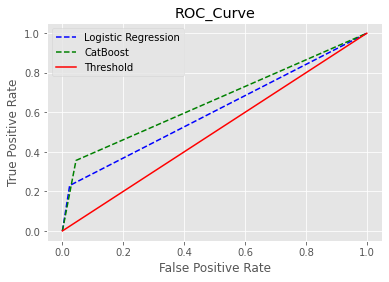

In [67]:
1 # ROC Curve Combined

fpr, tpr, threshold = roc_curve (y_test, y_pred, pos_label=1)
fpr1, tpr1, threshold1 = roc_curve (y_test, y_pred1, pos_label=1)

prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, _ = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr, tpr, linestyle="--", color='blue', label='Logistic Regression') 
plt.plot(fpr1, tpr1, linestyle="--", color='green', label='CatBoost')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label='Threshold')
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend (loc='best')
plt.plot(figsize=(6, 4.5))
plt.show()